In [1]:
# 0. Load keras package needed
import numpy as np
import tensorflow as tf
import keras
import os # drectory library
import cv2 # image processing library
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Input
from keras.layers import Flatten
from keras.layers import Input
from keras.layers import TimeDistributed
from keras import applications
from keras import optimizers
from keras.models import Model
from keras.models import load_model
# Fix random seed
np.random.seed(3)

2024-07-08 18:00:00.614982: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-08 18:00:00.615071: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-08 18:00:00.727888: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
timesteps = 22 # input frame numbers for LSTM
n_labels = 10 # Number of Dataset Labels
Learning_rate = 0.0001 # Oprimizers lr, in this case, for adam
batch_size = 16
validation_ratio = 0.2
num_epochs = 30
img_col = 128 # Transfer model input size ( MobileNet )
img_row = 128 # Transfer model input size ( MobileNet )
img_channel = 3 # RGB

In [3]:
#installing dataset
!pip install gdown
!gdown 1NlUocZpK0MJTeYhYsVm6OumN0utTUXQp

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Downloading...
From (original): https://drive.google.com/uc?id=1NlUocZpK0MJTeYhYsVm6OumN0utTUXQp
From (redirected): https://drive.google.com/uc?id=1NlUocZpK0MJTeYhYsVm6OumN0utTUXQp&confirm=t&uuid=4b686725-4866-42e3-845f-d655ad60c4a3
To: /kaggle/working/collected_data_finale.zip
100%|████████████████████████████████████████| 697M/697M [00:07<00:00, 88.2MB/s]


In [4]:
!unzip /kaggle/working/collected_data_finale.zip

Archive:  /kaggle/working/collected_data_finale.zip
   creating: collected_data/auto_1/
  inflating: collected_data/auto_1/0.png  
  inflating: collected_data/auto_1/1.png  
  inflating: collected_data/auto_1/10.png  
  inflating: collected_data/auto_1/11.png  
  inflating: collected_data/auto_1/12.png  
  inflating: collected_data/auto_1/13.png  
  inflating: collected_data/auto_1/14.png  
  inflating: collected_data/auto_1/15.png  
 extracting: collected_data/auto_1/16.png  
  inflating: collected_data/auto_1/17.png  
  inflating: collected_data/auto_1/18.png  
  inflating: collected_data/auto_1/19.png  
 extracting: collected_data/auto_1/2.png  
  inflating: collected_data/auto_1/20.png  
  inflating: collected_data/auto_1/21.png  
  inflating: collected_data/auto_1/3.png  
  inflating: collected_data/auto_1/4.png  
  inflating: collected_data/auto_1/5.png  
  inflating: collected_data/auto_1/6.png  
 extracting: collected_data/auto_1/7.png  
  inflating: collected_data/auto_1/8.png

In [5]:
# Define a dictionary mapping numeric labels to corresponding string labels
label_dict = {0: 'auto',
              1: 'cane',
              2: 'ciao',
              3: 'demo',
              4: 'gatto',
              5: 'moto',
              6: 'ok',
              7: 'pasta',
              8: 'pizza',
              9: 'uova'}

In [6]:
!cp -r /kaggle/working/collected_data/pizza_52 /kaggle/working/collected_data/pizza_22

In [7]:
from sklearn.preprocessing import LabelEncoder
import os
import cv2
import numpy as np

# Define temporary empty lists for loading data and labels
data = []  # List to store the image data
label = []  # List to store the corresponding labels
Totalnb = 0  # Initialize a counter for the total number of datasets

# label_dict is assumed to be a dictionary mapping class names to numeric labels
# timesteps is the number of time steps in each data sample
# img_col and img_row are the dimensions to which each image will be resized
# n_labels is the number of distinct labels in the dataset

# Load Dataset
for actual_label in label_dict:
    nb = 0  # Initialize a counter for the number of datasets for the current label

    # Traverse through directories to count datasets matching the current label
    for root, dirs, files in os.walk("/kaggle/working/collected_data/"):
        for name in dirs:
            lab = name.split("_")[0]  # Extract label from the directory name
            if lab == label_dict[actual_label]:
                nb += 1  # Increment counter if the label matches the current label in label_dict

    print(label_dict[actual_label], "Label number of Dataset is:", nb)
    Totalnb += nb  # Add to the total number of datasets

    # For each dataset under the current label, load the images
    for j in range(nb):
        temp = []  # Temporary list to hold images for the current dataset
        for i in range(timesteps):
            # Construct the image file path
            name = f'/kaggle/working/collected_data/{label_dict[actual_label]}_{j+1}/{i}.png'
            img = cv2.imread(name)  # Read the image

            if img is None:
                print(f"Error: Unable to read image '{name}'")
                print(f"Skipping...")
                # Skip this image and proceed to the next
            else:
                # Resize the image to the specified dimensions
                res = cv2.resize(img, dsize=(img_col, img_row), interpolation=cv2.INTER_CUBIC)
                temp.append(res)  # Append the resized image to the temporary list

        label.append(actual_label)  # Append the actual label to the labels list
        data.append(temp)  # Append the list of images to the data list

print("Total Number of Data is", Totalnb)

# Convert lists to numpy arrays for use with Keras or other ML frameworks
Train_label = np.eye(n_labels)[label]  # One-hot encode the labels
Train_data = np.array(data)  # Convert the list of data to a numpy array

# Print the shapes of the dataset and labels for verification
print("Dataset shape is", Train_data.shape, "(size, timestep, column, row, channel)")
print("Label shape is", Train_label.shape, "(size, label onehot vector)")


auto Label number of Dataset is: 66
cane Label number of Dataset is: 66
ciao Label number of Dataset is: 66
demo Label number of Dataset is: 66
gatto Label number of Dataset is: 66
moto Label number of Dataset is: 66
ok Label number of Dataset is: 66
pasta Label number of Dataset is: 66
pizza Label number of Dataset is: 66
uova Label number of Dataset is: 66
Total Number of Data is 660
Dataset shape is (660, 22, 128, 128, 3) (size, timestep, column, row, channel)
Label shape is (660, 10) (size, label onehot vector)


In [8]:
import gc
gc.collect()
!cat /proc/meminfo | grep Mem

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


MemTotal:       32880800 kB
MemFree:        17850916 kB
MemAvailable:   29757504 kB


In [9]:
# Shuffling the dataset to ensure the model trains properly
# Create an array of indices based on the number of samples in Train_label
x = np.arange(Train_label.shape[0])

# Shuffle the indices array randomly
np.random.shuffle(x)

# Shuffle Train_label and Train_data using the shuffled indices to maintain the same order
Train_label = Train_label[x]
Train_data = Train_data[x]

# Declare data for training (and validation, if needed)
# Here, the entire dataset is used for training, but it can be split further for validation and testing if desired
#X_train = Train_data[0:Totalnb, :]  # Select all data for training
#Y_train = Train_label[0:Totalnb]    # Select all corresponding labels for training


# Optionally, you can split X_train and Y_train further to create validation and test sets
# For example, to create a validation set, you might do:
test_split = 0.2  # Define the fraction of the dataset to be used for validation
split_index = int(Totalnb * (1 - test_split))  # Calculate the split index
X_test = Train_data[split_index:Totalnb, :]
Y_test = Train_label[split_index:Totalnb]
X_train = Train_data[0:split_index, :]
Y_train = Train_label[0:split_index]

print(Totalnb)
print(split_index)
print(X_train.shape)
print(X_test.shape)

660
528
(528, 22, 128, 128, 3)
(132, 22, 128, 128, 3)


In [10]:
# 2. Building a Model
# Declare the input layer for the CNN+LSTM architecture
video = Input(shape=(timesteps, img_col, img_row, img_channel))

# Load a pre-trained MobileNet model with specified input shape, pre-trained on ImageNet, excluding the top layers

#HERE YOU CAN CHOOSE THE MODEL:
#model = applications.MobileNet(input_shape=(img_col, img_row, img_channel), weights="imagenet", include_top=False)
model = applications.VGG16(input_shape=(img_col, img_row, img_channel), weights="imagenet", include_top=False)

model.trainable = False  # Freeze the pre-trained model layers to prevent them from being updated during training

# Fully Connected Dense Layer
x = model.output  # Get the output from the pre-trained model
x = Flatten()(x)  # Flatten the output to feed it into fully connected layers
x = Dense(1024, activation="relu")(x)  # Add a dense layer with 1024 units and ReLU activation
x = Dropout(0.3)(x)  # Add dropout for regularization to prevent overfitting
cnn_out = Dense(128, activation="relu")(x)  # Add another dense layer with 128 units and ReLU activation

# Construct the CNN model
Lstm_inp = Model(inputs=model.input, outputs=cnn_out)

# Add this method to mod to satisfy Keras's requirements
def compute_output_shape(input_shape):
    return (input_shape[0], 128)  # Adjust the shape as per your needs

Lstm_inp.compute_output_shape = compute_output_shape


# Distribute CNN output by timesteps using TimeDistributed layer
encoded_frames = TimeDistributed(Lstm_inp)(video)


# Construct LSTM model
encoded_sequence = LSTM(256)(encoded_frames)  # Add an LSTM layer with 256 units
hidden_Drop = Dropout(0.3)(encoded_sequence)  # Add dropout for regularization
hidden_layer = Dense(128, activation="relu")(hidden_Drop)  # Add a dense layer with 128 units and ReLU activation
outputs = Dense(n_labels, activation="softmax")(hidden_layer)  # Final output layer with softmax activation for classification

# Construct the complete CNN+LSTM model
model = Model(inputs=[video], outputs=outputs)

# 3. Setting up the Model Learning Process
# Compile the model with Adam optimizer and categorical crossentropy loss function
adam = keras.optimizers.Adam(learning_rate=Learning_rate, beta_1=0.9, beta_2=0.999, weight_decay=0.0, amsgrad=False)
model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])

# 4. Training the Model
# Train the model with the training data
hist = model.fit(X_train, Y_train, batch_size=batch_size, validation_split=validation_ratio, shuffle=True, epochs=num_epochs)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 44s 908ms/step - accuracy: 0.1290 - loss: 2.3636 - val_accuracy: 0.2453 - val_loss: 2.1366
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 18s 669ms/step - accuracy: 0.2801 - loss: 2.1048 - val_accuracy: 0.3396 - val_loss: 1.9336
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 18s 677ms/step - accuracy: 0.3707 - loss: 1.9171 - val_accuracy: 0.4434 - val_loss: 1.7258
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 18s 687ms/step - accuracy: 0.4358 - loss: 1.7636 - val_accuracy: 0.5566 - val_loss: 1.5495
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 698ms/step - accuracy: 0.5633 - loss: 1.5899 - val_accuracy: 0.5755 - val_loss: 1.3942
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 710ms/step - accuracy: 0.6346 - loss: 1.3709 - val_accuracy: 0.6415 - val_loss: 1.2100
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 710ms/step - accuracy: 0.6390 - loss: 1.2661 - val_accuracy: 0.7170 - val_loss: 1.1378
Epoch 8/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 705m

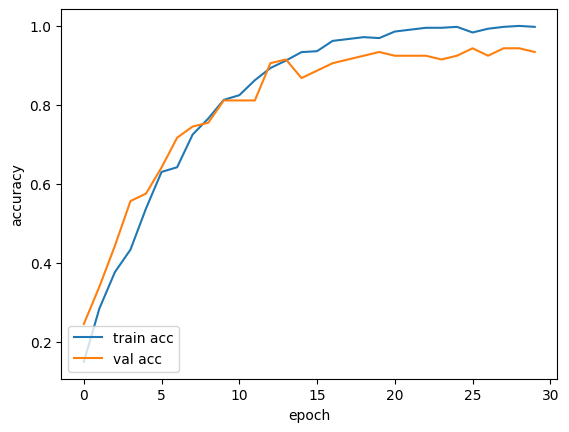

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

# Assuming 'hist' is your history object containing loss and accuracy history

# Create a figure and axis objects for loss and accuracy
fig, acc_ax = plt.subplots()

# Plot training and validation accuracy on the secondary y-axis
acc_ax.plot(hist.history['accuracy'], label='train acc')
acc_ax.plot(hist.history['val_accuracy'], label='val acc')

# Set the labels for the x-axis and y-axes
acc_ax.set_xlabel('epoch')
acc_ax.set_ylabel('accuracy')

# Add legends to the plot
acc_ax.legend(loc='lower left')  # Legend for accuracy

# Display the plot
plt.show()

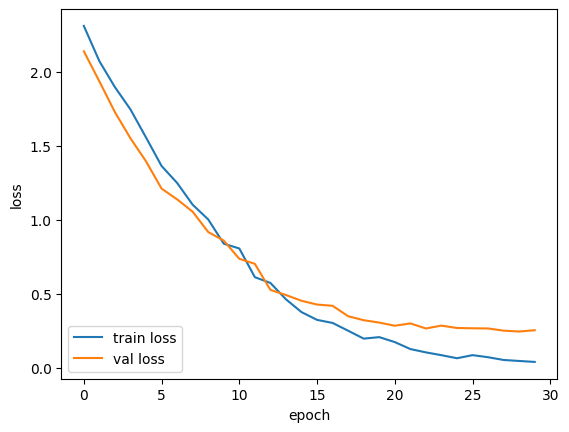

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

# Assuming 'hist' is your history object containing loss and accuracy history

# Create a figure and axis objects for loss and accuracy
fig, loss_ax = plt.subplots()

# Plot training and validation loss on the primary y-axis
loss_ax.plot(hist.history['loss'], label='train loss')
loss_ax.plot(hist.history['val_loss'], label='val loss')

# Set the labels for the x-axis and y-axes
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

# Add legends to the plot
loss_ax.legend(loc='lower left')  # Legend for loss

# Display the plot
plt.show()

In [13]:
Y_pred_prob = model.predict(X_test)
Y_pred = np.argmax(Y_pred_prob, axis=1)
Y_test = np.argmax(Y_test, axis=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step 


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 872ms/step


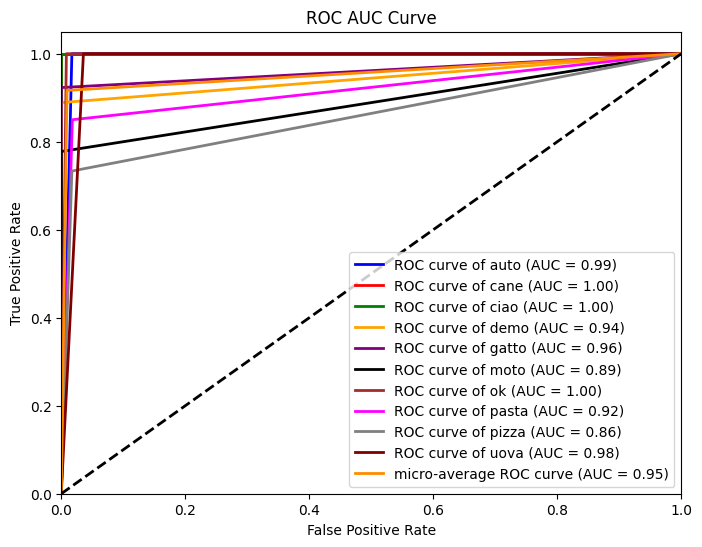

In [14]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have already loaded or defined Y_test, X_test, model, and label_dict somewhere

# Convert y_true and y_pred to one-hot encoding
n_classes = 10
Y_true_bin = label_binarize(Y_test, classes=np.arange(n_classes))
Y_pred_bin = model.predict(X_test)
Y_pred_bin = label_binarize(np.argmax(Y_pred_bin, axis=1), classes=np.arange(n_classes))

# Compute ROC curve and ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_true_bin[:, i], Y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC AUC
fpr_micro, tpr_micro, _ = roc_curve(Y_true_bin.ravel(), Y_pred_bin.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot ROC curves
plt.figure(figsize=(8, 6))
lw = 2
colors = ['blue', 'red', 'green', 'orange', 'purple', 'black', 'brown', 'magenta', 'gray', 'maroon', 'navy', 'olive', 'pink']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of {0} (AUC = {1:0.2f})'
             ''.format(label_dict[i], roc_auc[i]))
plt.plot(fpr_micro, tpr_micro, color='darkorange', lw=lw,
         label='micro-average ROC curve (AUC = {0:0.2f})'
         ''.format(roc_auc_micro))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc="lower right")
plt.show()


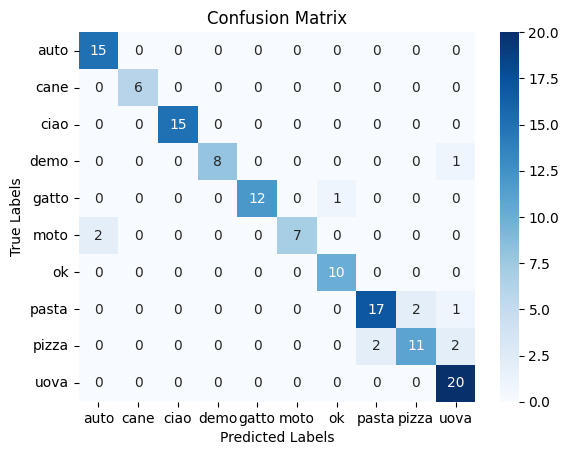

In [15]:
import sklearn
import seaborn as sns

conf_matrix = sklearn.metrics.confusion_matrix(Y_test, Y_pred)

#Define the list of label strings in the order of their integer values
label_strings = [label_dict[i] for i in range(len(label_dict))]

#Generate the heatmap confusion matrix
sns.heatmap(conf_matrix, annot=True, cmap="Blues", xticklabels=label_strings, yticklabels=label_strings)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

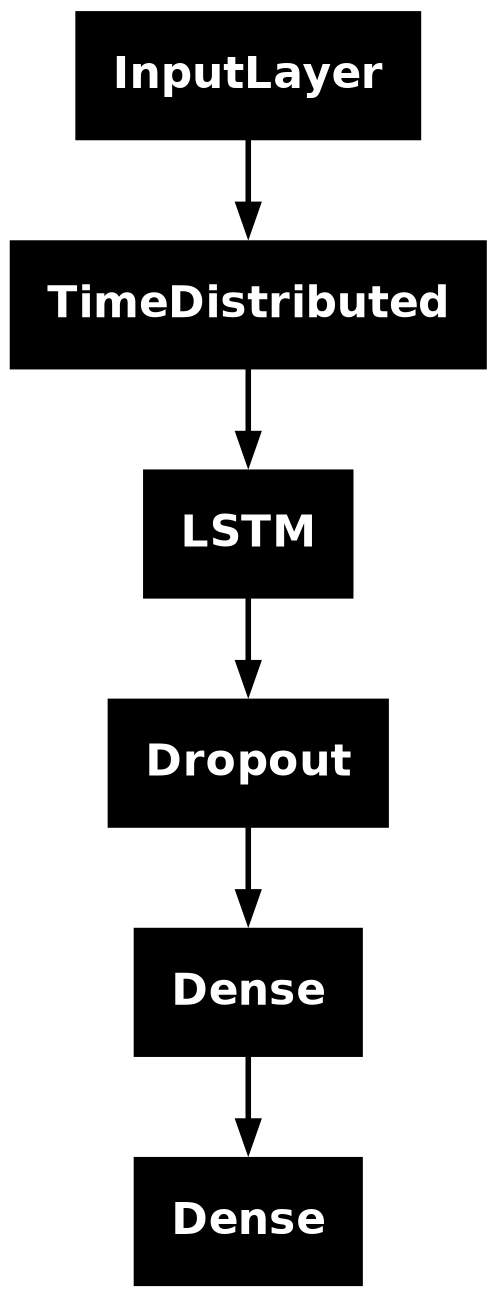

In [16]:
# Model Architecture Visualization
from IPython.display import SVG  # Import SVG display utilities from IPython
from keras.utils import model_to_dot  # Import model_to_dot for converting model architecture to dot format

# Enable inline display of plots in Jupyter notebooks
%matplotlib inline

# Convert the model to dot format and display it as an SVG
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

# Import plot_model for saving the model architecture as an image file
from keras.utils import plot_model

# Save the model architecture visualization to a file named 'model.png'
plot_model(model, to_file='model.png')


In [17]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 22, 128, 128,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 22, 128)        │    23,235,520 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,562,464 (158.55 MB)

 Trainable params: 8,949,258 (34.14 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 17,898,518 (68.28 MB)